<a href="https://colab.research.google.com/github/mahalingamagesthian/learningai/blob/main/10_SQLAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This page is inspired from https://langchain-ai.github.io/langgraph/tutorials/sql-agent/

In [1]:
pip install -U langgraph langchain_community "langchain[openai]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 12.9 MB/s eta 0:00:00


In SQL Agent project, this llm instance will be responsible for:

 * Translating your natural language questions into executable SQL queries.
 * Reasoning about the results returned from the database.
 * Deciding which tools to call (e.g., "query the database," "get table schema").
 * Synthesizing the final answer for the user based on the query results.

This is the central intelligence component of your agent.

1. `from langchain.chat_models import init_chat_model:`

   * `init_chat_model:` This is a convenient helper function from the langchain.chat_models module.
   * `Purpose`: Its purpose is to make it easy to initialize a chat model from various providers (like OpenAI, Anthropic, Google, etc.) with a simple string identifier. Instead of needing to know and import a specific class like ChatOpenAI, you can just use this function with a provider-specific string. This makes your code more portable and easier to read.
2. `llm = init_chat_model("openai:gpt-4.1"):`

   * `llm:` This is a standard variable name in LangChain for the initialized Language Model instance. You will use this variable to interact with the model throughout your code.
   * `"openai:gpt-4.1":` This is the key argument. It's a string that tells the init_chat_model function exactly which model to initialize.
      * `openai:` This is the provider. It specifies that you want to use a model from OpenAI.
      * `gpt-4.1:` This is the model name. It refers to a powerful and highly capable version of OpenAI's GPT-4 model, which is excellent for complex reasoning tasks like building a SQL agent.

In [2]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:··········


In [3]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1")

This script's purpose is to provide the **SQLite database file** (Chinook.db) that your SQL agent will connect to. After you run this code, the file will be stored locally, and your agent will be able to access its schema and execute queries against it in the next steps. It's a critical setup step that lays the groundwork for the agent's interaction with the data.

In [5]:
# 1. Import the necessary library
import requests
# 2. Define the URL of the database file
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
# 3. Send an HTTP GET request to download the file
response = requests.get(url)
# 4. Check if the download was successful
if response.status_code == 200:
    # 5. If successful, save the downloaded content to a local file
    # Open a local file in binary write mode ('wb')
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    # 6. If not successful, print an error message
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [6]:
# 1. Import the utility class for interacting with SQL databases
from langchain_community.utilities import SQLDatabase
# 2. Create a SQLDatabase instance from the local database file
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
# 3. Print the database dialect (type) to verify the connection
print(f"Dialect: {db.dialect}")
# 4. Get and print the names of all usable tables
print(f"Available tables: {db.get_usable_table_names()}")
# 5. Execute a raw SQL query and print a sample of the results
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


This step is a crucial bridge between your LLM and your database.

  * You've given the agent its brain (llm).
  * You've given it a database to work with (db).
  * This code gives the agent the hands (the tools) it needs to actually interact with that database.

1. `from langchain_community.agent_toolkits import SQLDatabaseToolkit:`

  * This line imports the SQLDatabaseToolkit class.
  * In **LangChain**, a Toolkit is a collection of related, pre-built Tool objects designed for a specific domain or purpose. This saves you from having to write each tool from scratch. This toolkit contains all the essential functions for interacting with a SQL database.

2. `toolkit = SQLDatabaseToolkit(db=db, llm=llm):`

  * This line creates an instance of the `SQLDatabaseToolkit`.
  * `db=db`: You are passing the SQLDatabase connection object (db) you created in the previous step. This is how the toolkit knows which database to connect to when its tools are called.
  * `llm=llm`: You are also passing your initialized LLM (llm). The toolkit uses the LLM for internal logic, such as getting the database schema, as it might need to reason about which tables to include in the context for the agent.
3. `tools = toolkit.get_tools():`

  * This line calls the `get_tools()` method on the toolkit instance.
  * This method's purpose is to generate and return a list of `Tool` objects that are part of the toolkit.
  * Each `Tool` object has a `name` and a `description` that the LLM can read and understand.
4. `for tool in tools: print(...):`

  * This is a simple for loop that iterates through the list of tools you just retrieved.
  * For each tool, it prints its `name` and `description`.

When you run this code, you will see a list of tools with descriptions similar to the following (the exact descriptions might vary slightly with library updates):

 * `sql_db_query`: A tool for executing a SQL query. The LLM will use this for the actual query execution.
 * `sql_db_schema`: A tool for getting the schema (table names and column names) of specific tables. The LLM will use this to understand the structure of the tables before writing a query.
 * `sql_db_list_tables`: A tool for listing all the tables in the database.
 * `sql_db_query_checker`: A helper tool that checks the validity of a SQL query before execution.


In [7]:
# 1. Import the SQLDatabaseToolkit class
from langchain_community.agent_toolkits import SQLDatabaseToolkit
# 2. Initialize the toolkit with your database connection and LLM
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

# 3. Get the list of pre-built tools from the toolkit
tools = toolkit.get_tools()
# 4. Iterate through the tools and print their names and descriptions
for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



**In the Context of Your SQL Agent Project:**

This code creates a single, `self-contained AI agent` that can now take a natural language question (e.g., "How many employees are in the Employee table?") and, using its internal reasoning loop and tools, figure out the necessary steps to answer it:

 * `Thought:` "The user wants to know the employee count. I should check the available tables first."
 * `Action:` Calls the `sql_db_list_tables` tool.
 * `Observation`: "The tables are Artist, Album, Employee, etc."
 * `Thought:` "Okay, I see an Employee table. Now I need to write a SQL query to count the rows."
 * `Action:` Calls the sql_db_query tool with SELECT COUNT(*) FROM Employee;.
 * `Observation`: "The query result is (8,)."
 * `Thought:` "I have the count. I can now provide the final answer."
 * `Final Answer:` "There are 8 employees in the database."

1. `from langgraph.prebuilt import create_react_agent:`

   * This line imports a pre-built function from the LangGraph library.
   * `create_react_agent`: This is a powerful helper function that simplifies the creation of a ReAct agent.
   * `ReAct (Reasoning and Acting):` This is a well-known agent pattern where the LLM follows an iterative cycle:
     * `Thought:` The LLM thinks about the user's request and decides on a plan.
     * `Action:` It calls one of its available tools (e.g., sql_db_query).
     * `Observation:` It receives the output from the tool (e.g., the result of the query).
     * `Thought...:` It then uses this observation to decide on the next step, repeating the cycle until it has a final answer.
  * langgraph.prebuilt provides this pattern out of the box, saving you from having to build the entire graph logic yourself.
2. `system_prompt = """...""".format(...):`

  * This code block defines the system prompt. This is a crucial instruction set that gives the LLM its identity, role, and rules of engagement.
  * `"""..."""`: This is a multi-line string that contains the detailed instructions for the agent.
  * `Role:` "You are an agent designed to interact with a SQL database." This immediately sets the context for the LLM.
  * `Instructions:` The prompt contains explicit rules and best practices for the agent's behavior:
    * `Query generation:` "create a syntactically correct... query."
    * `Result handling:` "look at the results... and return the answer."
    * **safeguards**
      * `LIMIT clause:` "always limit your query to at most {top_k} results."
      * This prevents the agent from fetching huge amounts of data and potentially running up costs or causing performance issues.
      * `Relevant columns:` "Never query for all the columns." This promotes efficiency.
      * `Double-checking queries:` "MUST double check your query before executing it." This is a key part of the agent's self-correction loop.
      * `DML statements:` "DO NOT make any DML statements." This is a critical security instruction to prevent the agent from modifying, deleting, or dropping data in the database.
      * `Initial steps:` "ALWAYS look at the tables..." This forces the agent to start by exploring the schema, which is a robust strategy for tackling a new database.
  * `.format(dialect=db.dialect, top_k=5,):` This uses Python's `str.format()` method to dynamically insert values into the prompt.
  * `{dialect}:` This placeholder will be replaced with 'sqlite', making the prompt specific to your database.
  * `{top_k}:` This placeholder is replaced with 5, setting the default query limit.

3. `agent = create_react_agent(...):`
  * This is where you assemble the agent.
  * `agent:` This variable now holds the compiled, ready-to-use ReAct agent. It's a runnable object.
  * `llm:` You are providing the LLM instance you initialized earlier (openai:gpt-4.1). This is the reasoning engine.
  * `tools:` You are providing the list of SQL tools you retrieved from the toolkit. These are the actions the agent can take.
  * `prompt=system_prompt:` You are giving the agent its identity and instructions through the system prompt you defined.



In [10]:
# 1. Import the prebuilt ReAct agent constructor from LangGraph
from langgraph.prebuilt import create_react_agent
# 2. Define the system prompt that gives the agent its identity and rules
system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

# 3. Create the agent instance
agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
)

In [11]:
question = "Which sales agent made the most in sales in 2009?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which sales agent made the most in sales in 2009?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_njlaLJkKEAnuF9RMvIkgKAEk)
 Call ID: call_njlaLJkKEAnuF9RMvIkgKAEk
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_e5Ez10h0U990WlGn8PbWyOIy)
 Call ID: call_e5Ez10h0U990WlGn8PbWyOIy
  Args:
    table_names: Employee, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Employee" (
	"EmployeeId" INTEGER NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"FirstName" NVARCHAR(20) NOT NULL, 
	"

This massive code block lays the groundwork for a highly modular and resilient SQL agent. Instead of a single LLM trying to do everything, you're creating specialized functions and nodes for distinct responsibilities:

  * **Schema Discovery**: Getting table information.
  * **Query Generation**: Writing the initial SQL.
  * **Query Checking/Correction**: Ensuring the SQL is valid and robust before execution.
  * **Query Execution:** Running the SQL against the database.
This multi-step approach with built-in **self-correction** (the check_query step) significantly improves the reliability and accuracy of your SQL agent, reducing "hallucinated" or incorrect queries. This is a common and effective pattern in advanced agent design.

Instead of relying on a single, general-purpose ReAct agent for all database interactions, this code defines individual specialized nodes and their logic, which you'll later connect in a LangGraph to create a precise workflow. This approach allows for detailed control over each step of the agent's reasoning, including crucial self-correction mechanisms.

1. **New Imports**
```
from typing import Literal # For type hints that specify exact string values
from langchain_core.messages import AIMessage # Represents an AI's message, including tool calls
from langchain_core.runnables import RunnableConfig # For configuration of runnables (less relevant here for explanation)
from langgraph.graph import END, START, MessagesState, StateGraph # Core LangGraph components
from langgraph.prebuilt import ToolNode # A specific type of LangGraph node for executing tools
```
`ToolNode:` This is a prebuilt `LangGraph` node type designed specifically to execute tools. When control reaches a `ToolNode`, it automatically calls the tool(s) associated with it and adds the `ToolMessage` (the output of the tool) to the state.

2. **Initializing ToolNodes for Direct Tool Execution**
```
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")
run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")
```
 * These lines extract specific `Tool` objects from your tools list (which you obtained from `SQLDatabaseToolkit`).
 * `next(tool for tool in tools if tool.name == "..."):` This is a Pythonic way to find the first tool in the tools list that matches a given name.
 * `get_schema_node = ToolNode([get_schema_tool], name="get_schema"):`
    * This creates a `ToolNode` named "get_schema". When `LangGraph` transitions to this node, it will automatically execute the `sql_db_schema` tool. The output (the database schema) will then be available in the graph's state.
 * `run_query_node = ToolNode([run_query_tool], name="run_query"):`
    * Similarly, this creates a ToolNode named "run_query". When this node is activated, it will execute the sql_db_query tool, running the SQL query that was provided to it (usually by a preceding LLM step).

3. **Example: Predetermined `Tool` Call (`list_tables` function)**
```
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123", # Manually creating an ID for the tool call
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    # Directly invoke the tool with the manually created tool_call
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}
```
 * **Purpose:** This function defines a node that programmatically executes a tool call without LLM reasoning. It's useful for fixed initial steps or known actions.
    * `tool_call = {...}:` Here, you're manually creating the dictionary representation of a tool call. This is how LangGraph (and LLMs) represent a tool invocation.
    * `"name":` The name of the tool to call.
    * `"args":` The arguments for the tool (empty for list_tables).
    * `"id":` A unique ID for this specific tool call.
    * `"type":` Indicates it's a tool_call.
 * `tool_call_message = AIMessage(content="", tool_calls=[tool_call]):` An `AIMessage` typically comes from an LLM. When you programmatically make a tool call that an LLM could have made, you wrap it in an `AIMessage` to maintain consistency in the `MessagesState`.
 * `list_tables_tool.invoke(tool_call):` This directly executes the underlying Python function associated with the `sql_db_list_tables` tool, passing the `tool_call` object.
 * `tool_message = list_tables_tool.invoke(tool_call):` The result of the tool's execution (a ToolMessage) is captured.
 * `response = AIMessage(...):` A final AIMessage is created to summarize the result of the list_tables action, making it clear in the conversation history.
 * `return {"messages": [...]}:` The `MessagesState` is updated with the `tool_call_message`, the `tool_message` (tool output), and the summarizing response.

4. **Example: Forcing a Model to Create a Tool Call (call_get_schema function)**
```
def call_get_schema(state: MessagesState):
    # Bind only the get_schema_tool to the LLM and force it to pick one (since only one is available)
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"]) # Invoke the LLM with the current messages

    return {"messages": [response]}
```
 * **Purpose:** This function defines a node where the **LLM is explicitly instructed** to make a tool call. This is useful for initial steps where you always want the LLM to perform a specific action, like getting schema, to inform its later reasoning.
 * `llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any"):`
    * `llm.bind_tools([...]):` This creates a new version of your llm instance that is aware of and can call only the specified tools (here, just get_schema_tool).
    * `tool_choice="any":` This is the key. It instructs the LLM that it must **choose one** of the available tools to respond. Since only `get_schema_tool` is provided, the LLM is effectively forced to generate a `tool_call` for `sql_db_schema`.
 * `response = llm_with_tools.invoke(state["messages"]):` The LLM is invoked with the current state["messages"]. Its response will be an AIMessage containing the tool_call for sql_db_schema.
 * `return {"messages": [response]}:` The `AIMessage` with the tool call is added to the state.

5. **Generating the Query (generate_query function)**
```
generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.
DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)
def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool]) # LLM can only call run_query_tool
    response = llm_with_tools.invoke([system_message] + state["messages"]) # Invoke with system prompt + current messages

    return {"messages": [response]}
```
 * **Purpose:** This node's responsibility is for the LLM to generate a SQL query based on the current context (including the user's initial question and any schema information gathered).
 * `generate_query_system_prompt:` This prompt specifically guides the LLM on how to generate SQL queries (limiting results, selecting relevant columns, avoiding DML, etc.).
 * `llm_with_tools = llm.bind_tools([run_query_tool]):` Here, we bind only the run_query_tool. This means the LLM's only callable action at this stage is to propose a SQL query by making a tool_call to run_query_tool. We do not use tool_choice="any" here, allowing the model some flexibility, though the prompt and tool binding strongly nudge it towards a tool call.
 * `response = llm_with_tools.invoke([system_message] + state["messages"]):` The LLM processes the combined messages (its system prompt plus the ongoing conversation history) and generates an AIMessage which should contain a tool_call to run_query_tool with the generated SQL query.

 6. **Checking the Query (check_query function)**

  ```
 check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
     - Using NOT IN with NULL values
     - Using UNION when UNION ALL should have been used
     - Using BETWEEN for exclusive ranges
     - Data type mismatch in predicates
     - Properly quoting identifiers
     - Using the correct number of arguments for functions
     - Casting to the correct data type
     - Using the proper columns for joins
If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.
You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)
def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Extract the previously generated tool call (which contains the SQL query)
    tool_call = state["messages"][-1].tool_calls[0]
    # Create an artificial user message with the query for the LLM to check
    user_message = {"role": "user", "content": tool_call["args"]["query"]}

    # Bind the run_query_tool and force the LLM to make a tool choice (either re-run or correct)
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    # Invoke the LLM with the check prompt and the query to be checked
    response = llm_with_tools.invoke([system_message, user_message])
    # IMPORTANT: Ensure the ID of the new tool_call matches the original one for LangGraph tracking
    response.id = state["messages"][-1].id

    return {"messages": [response]}
```

 * **Purpose:** This is a powerful **self-correction** mechanism. After generate_query proposes a SQL query, this node uses a separate LLM invocation to act as a "SQL expert" and critically review that query for common errors.
 * `check_query_system_prompt:` This detailed prompt explicitly lists common SQL pitfalls the LLM should look for. It instructs the LLM to either rewrite the query if mistakes are found or just reproduce it if it's correct. It also explicitly tells it to call a tool (which implies run_query_tool).
 * `tool_call = state["messages"][-1].tool_calls[0]:` This line retrieves the last AIMessage from the state, which is expected   to contain the tool call (with the SQL query) generated by the generate_query node. It then extracts that tool call.
 * `user_message = {"role": "user", "content": tool_call["args"]["query"]}:` A new "user" message is constructed. Its content is only the SQL query that needs to be checked. This focuses the checking LLM solely on the query itself.
 * `llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any"):`
  Again, the run_query_tool is bound, and tool_choice="any" is used. This forces the checking LLM to output a tool_call containing the (potentially corrected) query.
 * `response = llm_with_tools.invoke([system_message, user_message]):` The checking LLM processes its system prompt (check_query_system_prompt) and the specific user_message containing the query to be checked.

 * `response.id = state["messages"][-1].id:` This is a very important line! If the checking LLM rewrites the query, it will generate a new tool call ID. However, for LangGraph to correctly update the original tool call (from generate_query) with the checked/corrected one, the ID of the AIMessage containing the corrected tool call must match the ID of the original tool call that it's replacing. This ensures a seamless continuation of the tool execution.
 * `return {"messages": [response]}:` The AIMessage containing the (checked or corrected) tool_call for run_query_tool is added to the state.

In [8]:
from typing import Literal # For type hints that specify exact string values
from langchain_core.messages import AIMessage # Represents an AI's message, including tool calls
from langchain_core.runnables import RunnableConfig # For configuration of runnables (less relevant here for explanation)
from langgraph.graph import END, START, MessagesState, StateGraph # Core LangGraph components
from langgraph.prebuilt import ToolNode # A specific type of LangGraph node for executing tools


get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

**The Complete Workflow of Your SQL Agent:**
1. Start: User asks a question (e.g., "How many artists are there?").
2. List Tables (list_tables): Agent first gets a list of all tables in the database.
3. Call Get Schema (call_get_schema): Agent then requests the schema for relevant tables (e.g., Artist table).
4. Get Schema (Execute Tool) (get_schema): The sql_db_schema tool is actually executed, and the schema details are added to the state.
5. Generate Query (generate_query): The LLM, with the user's question and schema info, generates a SQL query (e.g., SELECT COUNT(*) FROM Artist;).
Conditional Check (should_continue):
  * If the LLM provided a SQL query, go to check_query.
  * If the LLM provided a direct answer (no tool call), END.
6. Check Query (check_query): The LLM reviews the generated SQL query for correctness and common errors, potentially rewriting it.
7. Run Query (run_query): The (checked/corrected) SQL query is executed against the Chinook.db database. The results are added to the state.
8. Loop Back to Generate Query (run_query -> generate_query): The agent returns to the generate_query step. The LLM now sees the results of the query it just ran. It can use these results to either formulate a final answer or decide it needs to execute another query (and loop through check/run again) to fully answer the user's question.
9. Loop Continues or Ends: This loop continues until the generate_query node produces a final answer without a tool call, at which point the should_continue function leads to END.

This piece of code brings together all the individual nodes and functions you defined previously and connects them to form the complete, intelligent, self-correcting SQL Agent workflow using LangGraph.

1. `should_continue` Function (Conditional Router)
```
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: # If the last message does NOT contain tool calls
        return END # The agent thinks it has a final answer
    else: # If the last message DOES contain tool calls (meaning a query was generated)
        return "check_query" # Go to the query checking step
```
  * **Purpose:** This function acts as a router or a decision point within your LangGraph. After a specific node (in this case, generate_query) completes its execution, LangGraph calls this should_continue function to determine what the next step in the workflow should be.
  * **Input:** It receives the current state of the graph, which includes the messages list.
  * **Logic**:
    * It looks at the last_message in the state["messages"].
    * if not last_message.tool_calls:: This is the core condition. If the last message from the generate_query LLM does not contain any tool calls, it means the LLM has concluded that it has successfully answered the user's question or can't proceed with another query. In this scenario, the graph's execution should END.
    * else: return "check_query": If the last_message does contain tool_calls (specifically, a call to run_query_tool with a generated SQL query), it means the generate_query node has proposed a SQL query. In this case, the should_continue function tells LangGraph to transition to the "check_query" node, where that proposed SQL query will be reviewed for errors.
  * `-> Literal[END, "check_query"]:` This is a type hint indicating that the function is expected to return either the END constant or the string "check_query", which are valid node names (or END signal) in LangGraph.

2. `**Building the Graph** (builder = StateGraph(MessagesState))`
This section defines the entire flow and connections between the nodes.

* `builder = StateGraph(MessagesState):`
  * Initializes a StateGraph, which is the core object for defining your graph's structure. It uses MessagesState to maintain the conversational history across all nodes.
* `builder.add_node(list_tables):`
  * Adds the list_tables function (which programmatically calls sql_db_list_tables) as a node in the graph. The node will be named "list_tables" implicitly by its function name.
* `builder.add_node(call_get_schema):`
  * Adds the call_get_schema function (which forces the LLM to call sql_db_schema) as a node named "call_get_schema".
* `builder.add_node(get_schema_node, "get_schema"):`
  * Adds the ToolNode you created earlier for directly executing sql_db_schema. It's explicitly named "get_schema" here.
* `builder.add_node(generate_query):`
 * Adds the generate_query function (where the LLM attempts to write a SQL query) as a node named "generate_query".
* `builder.add_node(check_query):`
 * Adds the check_query function (where the LLM reviews and potentially corrects the SQL query) as a node named "check_query".
* `builder.add_node(run_query_node, "run_query"):`
  * Adds the ToolNode you created earlier for directly executing sql_db_query. It's explicitly named "run_query".

3. **Defining Edges** (Flow of Control)
Edges define how control passes from one node to another.

* `builder.add_edge(START, "list_tables"):`

  * **Initial Entry Point:** When the graph starts (i.e., when you provide the initial user query), the execution begins by calling the list_tables node. This ensures the agent always starts by understanding the available tables.
* `builder.add_edge("list_tables", "call_get_schema"):`
  * After the list_tables node completes, control immediately passes to the call_get_schema node. This forces the agent to then obtain schema details (which will be crucial for writing accurate queries).
* `builder.add_edge("call_get_schema", "get_schema"):`
  * After call_get_schema (which generated a tool call for sql_db_schema), control passes to the get_schema node (the ToolNode that executes that tool call).
* `builder.add_edge("get_schema", "generate_query"):`
   * Once the schema information has been retrieved (by get_schema_node), control moves to the generate_query node, where the LLM will attempt to formulate a SQL query based on the user's input and the newly acquired schema knowledge.
* `builder.add_conditional_edges("generate_query", should_continue):`
   * This is where the dynamic routing happens. After the generate_query node finishes, the should_continue function is invoked.
   * If should_continue returns END (meaning the LLM has a final answer), the graph terminates.
   * If should_continue returns "check_query" (meaning the LLM proposed a SQL query), control is passed to the check_query node for verification.
* `builder.add_edge("check_query", "run_query"):`
   * If the query passes (or is corrected by) the check_query node, control then moves to the run_query node (the ToolNode that executes the sql_db_query tool).
* `builder.add_edge("run_query", "generate_query"):`
   * This creates a crucial loop for iteration and self-correction. After the run_query node executes the SQL query (and the result is added to the state), control is passed back to the generate_query node. This allows the LLM to:
      * See the results of the query it just ran.
      * Decide if the results are sufficient to answer the question, or if it needs to run another query (perhaps to refine the answer or explore further based on the initial results).
      * Potentially generate a final answer (leading to END via should_continue next time).
4. `agent = builder.compile()`
  * This is the final step. It takes the entire graph definition (nodes and edges) and compiles it into a runnable LangGraph agent object. This agent is now ready to take inputs and execute the sophisticated SQL interaction workflow.

In [9]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()

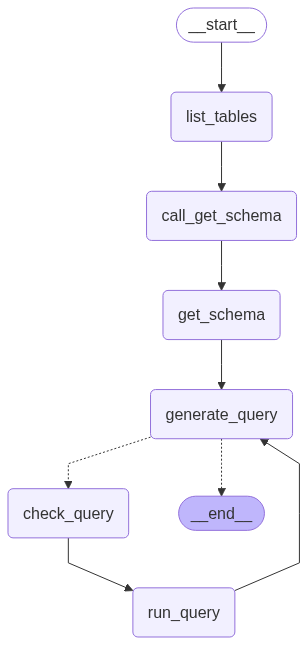

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
question = "Which sales agent made the most in sales in 2009?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which sales agent made the most in sales in 2009?
================================== Ai Message ==================================

Available tables: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_p9F2ygxhSVL7tg6G2HgkEnyp)
 Call ID: call_p9F2ygxhSVL7tg6G2HgkEnyp
  Args:
    table_names: Employee, Invoice, InvoiceLine
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Employee" (
	"EmployeeId" INTEGER NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"FirstName" NVARCHAR(20) NOT NULL, 
	"Title" NVARCHAR(30), 
	"ReportsTo" INTEGER, 
	"BirthDate" DATETIME, 
	"HireDate" DATETIME, 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40)